In [1]:
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')

### Data download

In [3]:
path = 'C:/Users/ASER/Desktop/GeekBrains\ML_project/tutor_selection/'

In [4]:
df = pd.read_csv(path  + 'train.csv')
df.head(2)

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points,choose
0,0,35.0,0.0,2150.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,74.0,0
1,1,52.0,2.0,1250.0,2.0,1.0,0.0,1.0,0.0,0.0,1.0,57.0,1


In [5]:
TARGET_NAME = 'choose'
X = df.drop(TARGET_NAME, axis=1)
y = df[TARGET_NAME]
print('X.shape = ', X.shape)
print('y.shape = ', y.shape)

X.shape =  (10000, 12)
y.shape =  (10000,)


In [6]:
y.value_counts()

0    8891
1    1109
Name: choose, dtype: int64

In [7]:
X_final = pd.read_csv(path  + 'test.csv')
print(X_final.shape)
X_final.head(2)

(10000, 12)


,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points
0,10000,32.0,2.0,2700.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0
1,10001,35.0,6.0,1800.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,71.0


In [8]:
y_submit = pd.read_csv(path  + 'submission_example.csv')
print(y_submit.shape)
y_submit.head(2)

(10000, 2)


,Id,choose
0,10000,0.5
1,10001,0.5


### EDA

In [9]:
FEATURE_NAMES = ['age', 'years_of_experience', 'lesson_price', 'qualification', 'mean_exam_points']
SUBJECTS = ['physics', 'chemistry', 'biology', 'english', 'geography', 'history' ]
NUMERIC_FEATURE_NAMES = FEATURE_NAMES + SUBJECTS

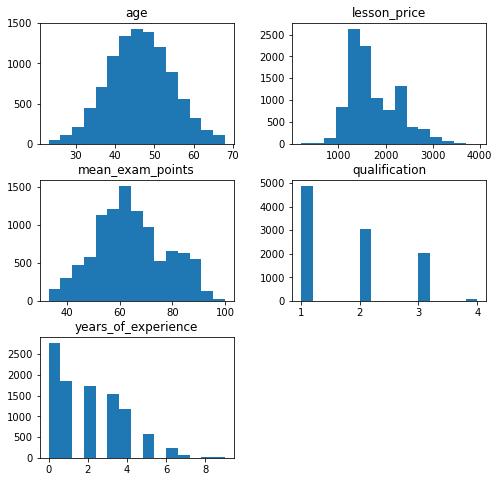

In [10]:
df.loc[:, FEATURE_NAMES].hist(figsize=(8, 8), bins=15, grid=False);

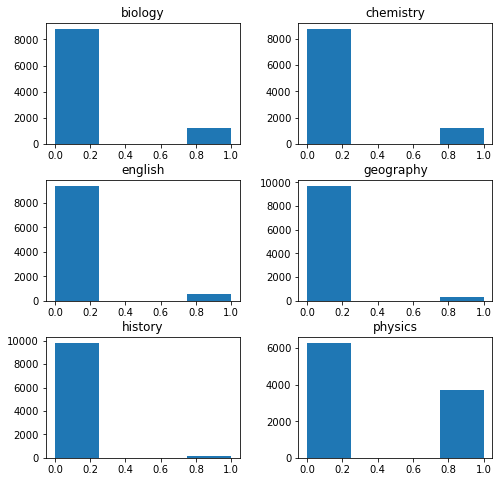

In [11]:
df.loc[:, SUBJECTS].hist(figsize=(8, 8), bins=4, grid=False);

In [12]:
len(df) - df.count()

Id                     0
age                    0
years_of_experience    0
lesson_price           0
qualification          0
physics                0
chemistry              0
biology                0
english                0
geography              0
history                0
mean_exam_points       0
choose                 0
dtype: int64

### Data Engineering

In [13]:
class FeatureGenerator:
    def __init__(self):
        self.var_grades = {'age': [40, 53, 59, 9999],
                           'years_of_experience': [6, 9999],
                           'lesson_price': [1200, 1600, 2500, 9999],
                           'mean_exam_points': [55, 60, 65, 70, 75, 85, 9999],
                           'qualification': [1, 2, 3, 4],
                           'subject': [0, 1]}
        

   # age, years_of_experience, lesson_price, mean_exam_points    
    def WOE_calc1(self, var_name):
        WOE = {} 
        i0 = 0
        for i in self.var_grades[var_name]:
            a = df.loc[(df[var_name] >= i0) & (df[var_name] < i), 'choose'].mean()
            WOE[i] = np.log(a / (1 - a))
            i0 = i  
        return WOE     
    
    
    def fit(self, X, y=None):
        df = X.copy()
        
        if y is not None:
            df['choose'] = y.values
            
            self.age_WOE = self.WOE_calc1(var_name='age')
            self.years_of_experience_WOE = self.WOE_calc1(var_name='years_of_experience')
            self.lesson_price_WOE = self.WOE_calc1(var_name='lesson_price')
            self.mean_exam_points_WOE = self.WOE_calc1(var_name='mean_exam_points')            
            
            # qualification
            WOE = {} 
            i0 = 0
            for i in self.var_grades['qualification']:
                a = df.loc[df['qualification'] == i, 'choose'].mean()
                WOE[i] = np.log(a / (1 - a))
                i0 = i
            self.qualification_WOE = WOE                
            
            # SUBJECTS
            WOE_collection = {}
            for subject in SUBJECTS:
                WOE = {}
                for i in self.var_grades['subject']:
                    a=df.loc[df[subject]==i, 'choose'].mean()
                    df.loc[df[subject]==i, subject] = np.log(a / (1 - a))
                    WOE[i] = np.log(a / (1 - a))
                WOE_collection[subject] = WOE
            self.subjects_WOE = WOE_collection
        
            
    def transform(self, X):
        # age
        i0 = 0
        for i in self.var_grades['age']:
            X.loc[(X.age >= i0) & (X.age < i), 'age'] = self.age_WOE[i] 
            i0 = i
            
        # years_of_experience
        i0 = 0
        for i in self.var_grades['years_of_experience']:
            X.loc[(X.years_of_experience >= i0) & (X.years_of_experience < i), 'years_of_experience'] =\
                                                                                 self.years_of_experience_WOE[i] 
            i0 = i
        
        # lesson_price
        i0 = 0
        for i in self.var_grades['lesson_price']:
            X.loc[(X.lesson_price >= i0) & (X.lesson_price < i), 'lesson_price'] = self.lesson_price_WOE[i] 
            i0 = i
            
        # mean_exam_points
        i0 = 0
        for i in self.var_grades['mean_exam_points']:
            X.loc[(X.mean_exam_points >= i0) & (X.mean_exam_points < i), 'mean_exam_points'] = self.mean_exam_points_WOE[i] 
            i0 = i
            
        # qualification
        for i in self.var_grades['qualification']:   
            X.loc[X.qualification == i, 'qualification'] = self.qualification_WOE[i]
        
        # SUBJECTS
        for subject in SUBJECTS:
            for i in self.var_grades['subject']: 
                X.loc[X[subject] == i, subject] = self.subjects_WOE[subject][i]
                
        return X

### Разбивка выборки на тренировочную и тестовую

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    shuffle=True,
                                                    stratify = y,
                                                    test_size=0.5, random_state=42)

In [15]:
features = FeatureGenerator()
features.fit(X_train, y_train)
X_train = features.transform(X_train)
X_test = features.transform(X_test)

### Отбор признаков

In [16]:
SELECTED_FEATURE_NAMES = ['age', 'years_of_experience', 'lesson_price', 'mean_exam_points', 'qualification',
                          'physics', 'chemistry', 'biology', 'english', 'geography', 'history'
                         ]

### Модель

In [17]:
class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [18]:
class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        z = np.mean(self.labels)
        return 1 / (1 + np.exp(-z)) #0.55

In [19]:
random.seed(42)

class RandomForest:
    
    def __init__(self, n_trees, min_leaf, criteria):
        self.n_trees = n_trees
        self.min_leaf = min_leaf
        self.criteria = criteria
             
        
    def info_criteria(self, labels):
        if self.criteria=='variance': 
            return np.mean((labels - np.mean(labels))**2) 
        #  подсчет количества объектов разных классов
        classes = {}
        for label in labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1

        #  расчет критерия
        entropy_ = 0
        impurity = 1    
        for label in classes:
            p = classes[label] / len(labels)
            entropy_ -= p * np.log2(p)
            impurity -= p ** 2    

        if self.criteria == 'entropy':        
            return entropy_
        elif self.criteria == 'gini':
            return impurity
        
        
    # Расчет качества
    def quality(self, true_labels, false_labels, current_criteria):        
        # доля выбоки, ушедшая в левое поддерево
        p = float(true_labels.shape[0]) / (true_labels.shape[0] + false_labels.shape[0])
        return current_criteria - p * self.info_criteria(true_labels) - (1 - p) * self.info_criteria(false_labels)         
        
        
    # Разбиение датасета в узле
    def split(self, data, labels, index, t):

        left = np.where(data[:, index] <= t)
        right = np.where(data[:, index] > t)

        true_data = data[left]
        false_data = data[right]
        true_labels = labels[left]
        false_labels = labels[right]

        return true_data, false_data, true_labels, false_labels
    
    
    def get_subsample(self, n_features):
        # будем сохранять не сами признаки, а их индексы
        sample_indexes = [i for i in range(n_features)]

        len_subsample = int(np.sqrt(n_features))
        subsample = []

        random.shuffle(sample_indexes)
        for _ in range(len_subsample):
            subsample.append(sample_indexes.pop())

        return subsample
        
        
    # Нахождение наилучшего разбиения
    def find_best_split(self, data, labels):

        current_criteria = self.info_criteria(labels)

        best_quality = 0
        best_t = None
        best_index = None        
        
        n_features = data.shape[1]
    
        # выбор индекса из подвыборки длиной sqrt(n_features)
        subsample = self.get_subsample(n_features)

        for index in subsample:
            # будем проверять только уникальные значения признака, исключая повторения
            t_values = np.unique([row[index] for row in data])

            for t in t_values:
                true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)
                
                #  пропускаем разбиения, в которых в узле остается менее 5 объектов
                if len(true_data) < self.min_leaf or len(false_data) < self.min_leaf:
                    continue

                current_quality = self.quality(true_labels, false_labels, current_criteria)

                #  выбираем порог, на котором получается максимальный прирост качества
                if current_quality > best_quality:
                    best_quality, best_t, best_index = current_quality, t, index
                    
        return best_quality, best_t, best_index        
          
        
    # Построение дерева с помощью рекурсивной функции
    def build_tree(self, data, labels): 

        quality, t, index = self.find_best_split(data, labels)        

        #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
        if quality == 0:
            return Leaf(data, labels)

        true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)        

        # Рекурсивно строим два поддерева
        true_branch = self.build_tree(true_data, true_labels)
        false_branch = self.build_tree(false_data, false_labels)

        # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева        
        return Node(index, t, true_branch, false_branch)
    
    
    
    def get_bootstrap(self, data, labels):
        n_samples = data.shape[0]
        bootstrap = []        
       
        for i in range(self.n_trees):
            b_data = np.zeros(data.shape)
            b_labels = np.zeros(labels.shape)            
          
            for j in range(n_samples):
                sample_index = random.randint(0, n_samples-1) 
                b_data[j] = data[sample_index]
                b_labels[j] = labels[sample_index]                
                
            bootstrap.append((b_data, b_labels))
        
        return bootstrap
 
         
    def fit(self, data, labels):
        forest = []
        bootstrap = self.get_bootstrap(data, labels)

        for b_data, b_labels in bootstrap:            
            forest.append(self.build_tree(b_data, b_labels))
            
        self.forest = forest
        
    
    def classify_object(self, obj, node):
        #  Останавливаем рекурсию, если достигли листа
        if isinstance(node, Leaf):
            answer = node.prediction
            return answer

        if obj[node.index] <= node.t:
            return self.classify_object(obj, node.true_branch)
        else:
            return self.classify_object(obj, node.false_branch)
        
        
    def predict_tree(self, data, tree):        
        classes = []
        for obj in data:
            prediction = self.classify_object(obj, tree)        
            classes.append(prediction)
        return classes
    
    
    # предсказание голосованием деревьев
    def predict(self, data):
        # добавим предсказания всех деревьев в список
        predictions = []
        for tree in self.forest:
            predictions.append(self.predict_tree(data, tree))

        # сформируем список с предсказаниями для каждого объекта
        predictions_per_object = list(zip(*predictions))

        # выберем в качестве итогового предсказания для каждого объекта то,
        # за которое проголосовало большинство деревьев
        voted_predictions = []
        for obj in predictions_per_object:
            voted_predictions.append(max(set(obj), key=obj.count))

        return voted_predictions

In [20]:
def metrics(y, y_pred):
    y = y.values
    y_pred = np.array(y_pred)
    sum_0 = 0
    sum_1 = 0
    for i in range(len(y)):
        for j in range(len(y)):
            if y_pred[i] > y_pred[j]: ind_pred = 0 
            if y_pred[i] ==y_pred[j]: ind_pred = 0.5
            if y_pred[i] < y_pred[j]: ind_pred = 1

            if y[i] >=y[j]: ind_y = 0
            if y[i] < y[j]: ind_y = 1

            sum_0 += ind_pred * ind_y
            sum_1 += ind_y

    AUC_ROC_score = sum_0 / sum_1
    print('AUC_ROC_score = ', AUC_ROC_score) 

In [21]:
forest = RandomForest(n_trees=50, min_leaf=12, criteria='entropy') #gini
forest.fit(np.array(X_train[SELECTED_FEATURE_NAMES]), np.array(y_train))

y_pred_train = forest.predict(np.array(X_train[SELECTED_FEATURE_NAMES]))
y_pred_test = forest.predict(np.array(X_test[SELECTED_FEATURE_NAMES]))

In [22]:
metrics(y_train, y_pred_train)

AUC_ROC_score =  0.8105724622260055


In [23]:
metrics(y_test, y_pred_test)

AUC_ROC_score =  0.721709450428812


### Прогнозирование на тестовом датасете

In [24]:
features = FeatureGenerator()
features.fit(X, y)
X = features.transform(X)
X_final = features.transform(X_final)

In [25]:
forest.fit(np.array(X[SELECTED_FEATURE_NAMES]), np.array(y))
y_pred_final = forest.predict(np.array(X_final[SELECTED_FEATURE_NAMES]))

In [26]:
y_submit['choose'] = y_pred_final
y_submit.to_csv(path + 'predictions.csv', index=False)
y_submit.head(2)

,Id,choose
0,10000,0.500000
1,10001,0.549834
